### Supervised

In [1]:
# import modules and libraries
import torch
import torch.nn as nn
from torch.optim import Adam

# functions to create datasets and models
from data.data import *
from models.models import *

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    device = torch.device('cuda')

CUDA is available


### Parameters

In [3]:
"""Parameters for this experiment"""
# params for loading the data
path = 'data/CWRU/bearing/'
source_domain = 'E'
target_domains = ['F', 'G', 'H', 'A', 'B', 'C', 'D']

# params for configuring the model
input_dim = 1
hidden_dim = 256
output_dim = 10
drop_prob = 0.5

# params for training the model
epochs_pre = 30 # pre-training
epochs = 30

# optimizing the model
lr = 1e-4
batch_size = 20
beta1 = 0.5
beta2 = 0.9

### Data Loading

In [4]:
# source domain data for training, validating and testing
train_dataloader_src, val_dataloader_src, test_dataloader_src = generate_dataloaders(path, source_domain, batch_size)

# target domain data for validating and testing
train_dataloader_tgt, val_dataloader_tgt, test_dataloader_tgt = [], [], []
for target_domain in target_domains:
    train_dataloader_temp, val_dataloader_temp, test_dataloader_temp = generate_dataloaders(path, target_domain, batch_size)
    
    train_dataloader_tgt.append(train_dataloader_temp)
    val_dataloader_tgt.append(val_dataloader_temp)
    test_dataloader_tgt.append(test_dataloader_temp)

### Model

In [5]:
encoder_src = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim # hidden layers 256
)

classifier = Classifier_AMDA(
    hidden_dim=hidden_dim, # hidden layers 256
    output_dim=output_dim, # 3 classes (healthy, inner- and outer-bearing damages)
    dropout=drop_prob # dropout prob 0.5
)

encoder_tgt = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim, # hidden layers 256
)

if train_on_gpu:
    encoder_src = encoder_src.to(device)
    classifier = classifier.to(device)
    encoder_tgt = encoder_tgt.to(device)

#### Functions for training and testing the model

In [6]:
# functions for training source encoder and shared classifier
def train_src(encoder, classifier):
    """Train the source encoder and shared classifier on source domain"""
    encoder.train()
    classifier.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(
        list(encoder.parameters()) + list(classifier.parameters()),
        lr=lr,
        betas=(beta1, beta2)
    )

    for epoch in range(epochs_pre):
        accuracies = []
        losses = []

        for batch_idx, (x_src, y_src) in enumerate(train_dataloader_src):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            optimizer.zero_grad()

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            loss_src.backward()

            optimizer.step()

            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
        
        # print for each epoch
        print(f'Epoch: {epoch + 1} \n \t Train Loss:{torch.tensor(losses).mean():0.2f} \t Train Acc:{torch.tensor(accuracies).mean():0.2f}')

        # for each epoch, evaluate your model on the validation data
        val_loss, val_acc = evaluate_src(encoder, classifier, phase = 'Val')
        print(f'\t Val Loss:{val_loss:0.2f} \t\t Val Acc:{val_acc:0.2f}')

    return encoder, classifier

# testing model on source domain
def evaluate_src(encoder, classifier, phase='Val'): # phase can be validate or test
    """Evaluate the trained network on source domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    dataloader = val_dataloader_src if phase == 'Val' else test_dataloader_src
    
    with torch.no_grad():
        for batch_idx, (x_src, y_src) in enumerate(dataloader):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            
            # append loss for each batch
            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [7]:
# Continuous Unsupervised Adaptation (CUA)
# functions for training target encoder
def train_tgt(encoder_src, encoder_tgt, classifier, phase):
    """Train the target encoder on target domains with source encoder and test the network"""
    encoder_tgt.train()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(
        encoder_tgt.parameters(),
        lr=lr,
        betas=(beta1, beta2)
    )

    for epoch in range(epochs):
        losses = []
        accuracies = []

        for batch_idx, ((x_src, y_src), (x_tgt, y_tgt)) in enumerate(zip(train_dataloader_src, train_dataloader_tgt[phase])):
            if(train_on_gpu):
                x_src, y_src = x_src.to(device), y_src.to(device)
                x_tgt, y_tgt = x_tgt.to(device), y_tgt.to(device)

            optimizer.zero_grad()

            e_src = encoder_tgt(x_src)
            pred_src = classifier(e_src)
            e_tgt = encoder_tgt(x_tgt)
            pred_tgt = classifier(e_tgt)
            loss_src = criterion(pred_src, y_src)
            loss_tgt = criterion(pred_tgt, y_tgt)
            loss = loss_src + loss_tgt
            loss.backward()

            optimizer.step()

            # training (with replay) losses and accuracies
            losses.append(loss.detach().item()) # detach the loss from compute graph
            accuracies.append(y_tgt.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
        
        # print for each epoch
        print(f'Epoch: {epoch + 1} \n \t Train Loss:{torch.tensor(losses).mean():0.2f} \t Train Acc:{torch.tensor(accuracies).mean():0.2f}')
        
        # for each epoch, evaluate your model on the validation data
        val_loss, val_acc = evaluate_tgt(encoder_tgt, classifier, val_dataloader_tgt[phase])
        print(f'\t Val (with Target) Loss:{val_loss:0.2f} \t Val (with Target) Acc:{val_acc:0.2f}')

    return encoder_tgt
    
# testing model on target domains
def evaluate_tgt(encoder, classifier, dataloader):
    """Evaluate the network on current target domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dataloader): # target dataloader
            if(train_on_gpu):
                x, y = x.to(device), y.to(device)

            pred_tgt = classifier(encoder(x))
            loss_tgt = criterion(pred_tgt, y)
            
            # append loss for each batch
            losses.append(loss_tgt.detach().item()) # detach the loss from compute graph 
            accuracies.append(y.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [8]:
# pre-training
encoder_src, classifier = train_src(encoder_src, classifier)
torch.save(encoder_src.state_dict(), './dump/source_encoder_cwru_supervised5.pt')
torch.save(classifier.state_dict(), './dump/classifier_cwru_supervised5.pt')
# encoder_src.load_state_dict(torch.load('./dump/source_encoder_cwru_supervised5.pt'))
# classifier.load_state_dict(torch.load('./dump/classifier_cwru_supervised5.pt'))
src_test_loss, src_test_acc = evaluate_src(encoder_src, classifier, phase='Test')
print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 

Epoch: 1 
 	 Train Loss:2.28 	 Train Acc:0.13
	 Val Loss:2.17 		 Val Acc:0.11
Epoch: 2 
 	 Train Loss:1.98 	 Train Acc:0.22
	 Val Loss:1.72 		 Val Acc:0.30
Epoch: 3 
 	 Train Loss:1.47 	 Train Acc:0.46
	 Val Loss:1.20 		 Val Acc:0.61
Epoch: 4 
 	 Train Loss:1.04 	 Train Acc:0.67
	 Val Loss:0.90 		 Val Acc:0.65
Epoch: 5 
 	 Train Loss:0.81 	 Train Acc:0.73
	 Val Loss:0.74 		 Val Acc:0.68
Epoch: 6 
 	 Train Loss:0.69 	 Train Acc:0.75
	 Val Loss:0.64 		 Val Acc:0.78
Epoch: 7 
 	 Train Loss:0.60 	 Train Acc:0.78
	 Val Loss:0.60 		 Val Acc:0.75
Epoch: 8 
 	 Train Loss:0.55 	 Train Acc:0.80
	 Val Loss:0.51 		 Val Acc:0.80
Epoch: 9 
 	 Train Loss:0.49 	 Train Acc:0.82
	 Val Loss:0.52 		 Val Acc:0.78
Epoch: 10 
 	 Train Loss:0.45 	 Train Acc:0.84
	 Val Loss:0.47 		 Val Acc:0.82
Epoch: 11 
 	 Train Loss:0.40 	 Train Acc:0.86
	 Val Loss:0.44 		 Val Acc:0.83
Epoch: 12 
 	 Train Loss:0.36 	 Train Acc:0.88
	 Val Loss:0.35 		 Val Acc:0.88
Epoch: 13 
 	 Train Loss:0.32 	 Train Acc:0.89
	 Val Loss:0.3

### Continuous Unsupervised Adaptation

In [9]:
encoder_tgt.load_state_dict(encoder_src.state_dict())

# adaptation
for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')
    
    encoder_tgt = train_tgt(encoder_src, encoder_tgt, classifier, phase)
    
    print('\nTesting Accuracy on Previously Seen and Current Domains:')
    print(f'Source Domain {source_domain}:')
    src_test_loss, src_test_acc = evaluate_src(encoder_tgt, classifier, phase='Test')
    print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
    for p in range(phase + 1):
        print(f'Target Domain {target_domains[p]}:')
        tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt, classifier, test_dataloader_tgt[p])
        print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}')


Phase 1 (Domain E to Domain F)
Epoch: 1 
 	 Train Loss:4.86 	 Train Acc:0.67
	 Val (with Target) Loss:2.00 	 Val (with Target) Acc:0.66
Epoch: 2 
 	 Train Loss:1.80 	 Train Acc:0.71
	 Val (with Target) Loss:1.05 	 Val (with Target) Acc:0.72
Epoch: 3 
 	 Train Loss:1.27 	 Train Acc:0.74
	 Val (with Target) Loss:0.76 	 Val (with Target) Acc:0.77
Epoch: 4 
 	 Train Loss:1.10 	 Train Acc:0.75
	 Val (with Target) Loss:0.68 	 Val (with Target) Acc:0.76
Epoch: 5 
 	 Train Loss:0.98 	 Train Acc:0.77
	 Val (with Target) Loss:0.60 	 Val (with Target) Acc:0.77
Epoch: 6 
 	 Train Loss:0.89 	 Train Acc:0.79
	 Val (with Target) Loss:0.57 	 Val (with Target) Acc:0.77
Epoch: 7 
 	 Train Loss:0.81 	 Train Acc:0.81
	 Val (with Target) Loss:0.50 	 Val (with Target) Acc:0.84
Epoch: 8 
 	 Train Loss:0.75 	 Train Acc:0.83
	 Val (with Target) Loss:0.45 	 Val (with Target) Acc:0.89
Epoch: 9 
 	 Train Loss:0.69 	 Train Acc:0.85
	 Val (with Target) Loss:0.42 	 Val (with Target) Acc:0.89
Epoch: 10 
 	 Train Los

	 Test (with Source) Loss:0.11 	 Test (with Source) Acc:0.96

Phase 1 (Domain E to Domain F)
	 Test (with Target) Loss:5.05 	 Test (with Target) Acc:0.72

Phase 2 (Domain F to Domain G)
	 Test (with Target) Loss:4.43 	 Test (with Target) Acc:0.73

Phase 3 (Domain G to Domain H)
	 Test (with Target) Loss:5.97 	 Test (with Target) Acc:0.66

Phase 4 (Domain H to Domain A)
	 Test (with Target) Loss:1.21 	 Test (with Target) Acc:0.80

Phase 5 (Domain A to Domain B)
	 Test (with Target) Loss:0.34 	 Test (with Target) Acc:0.93

Phase 6 (Domain B to Domain C)
	 Test (with Target) Loss:0.05 	 Test (with Target) Acc:0.98

Phase 7 (Domain C to Domain D)
	 Test (with Target) Loss:0.03 	 Test (with Target) Acc:0.99


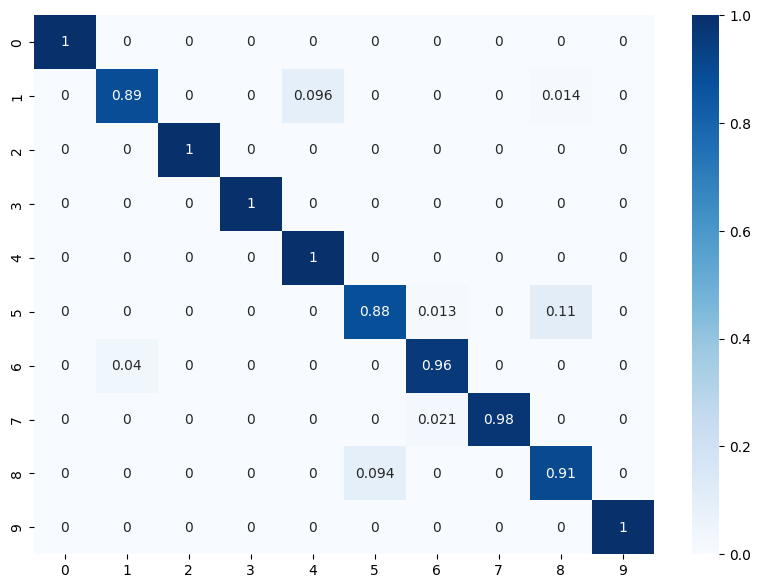

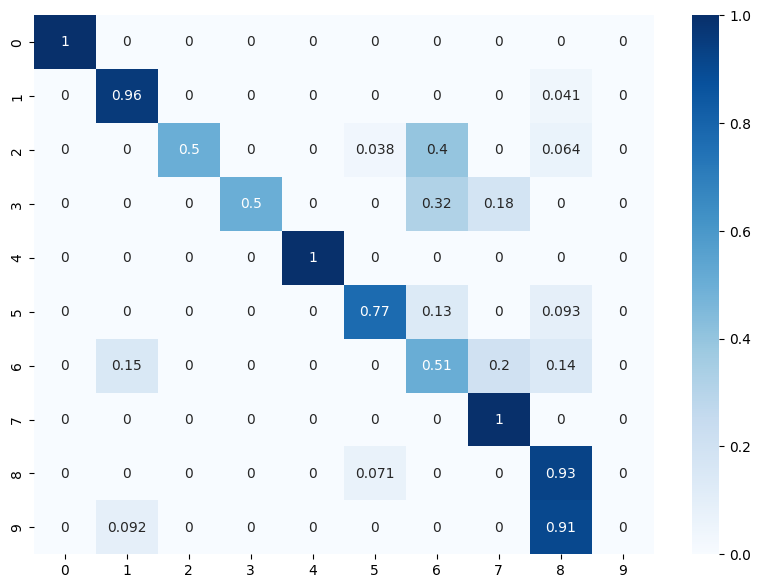

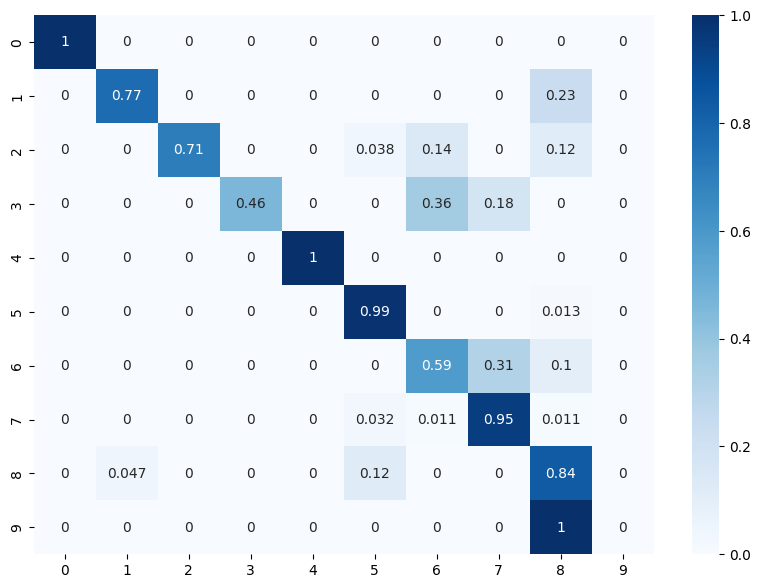

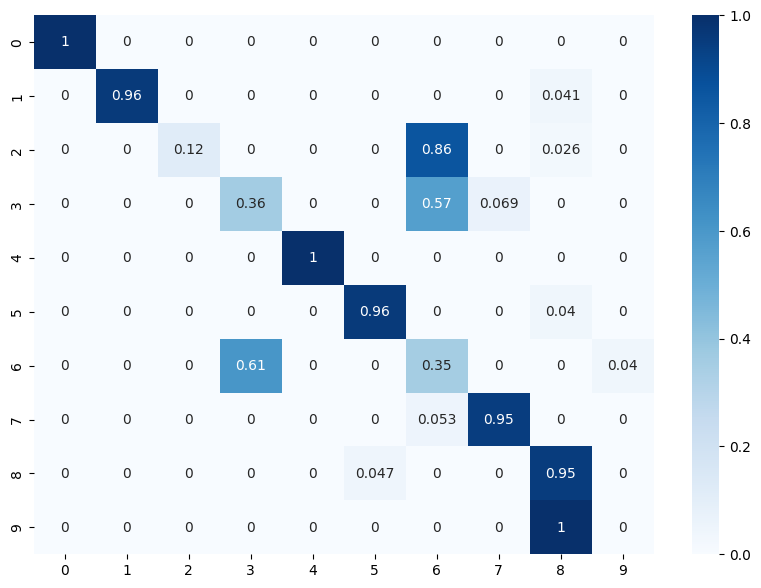

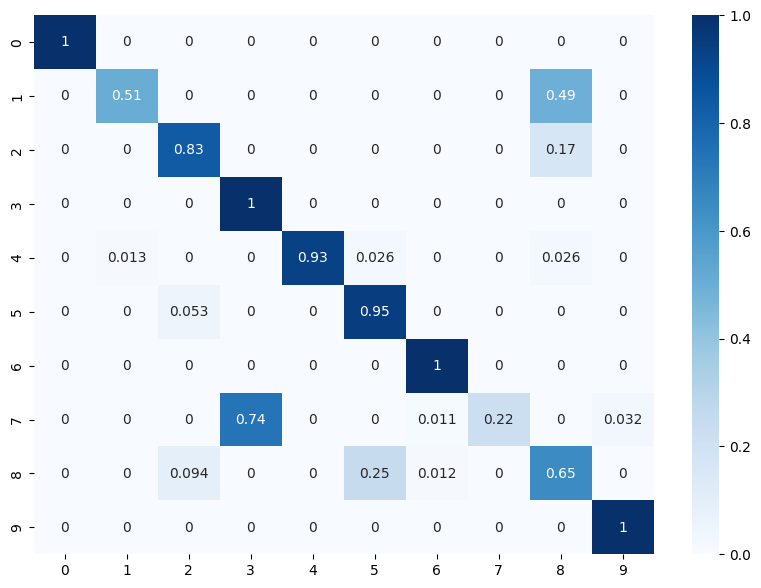

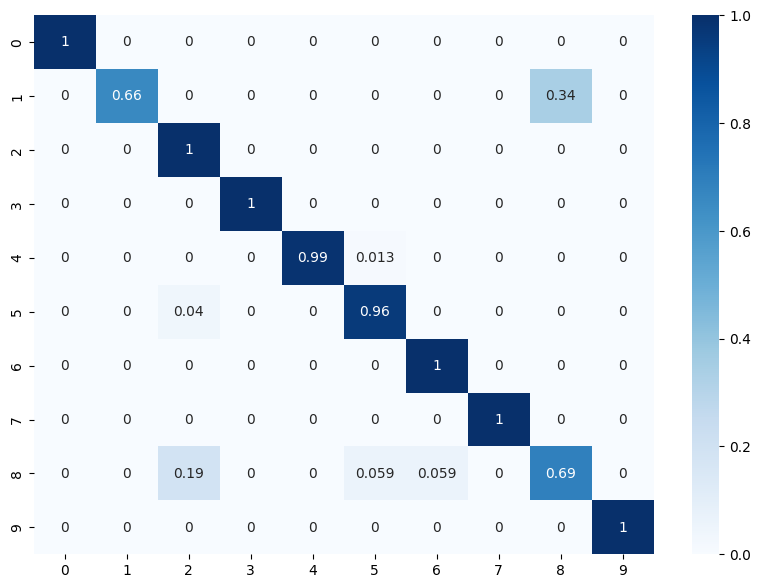

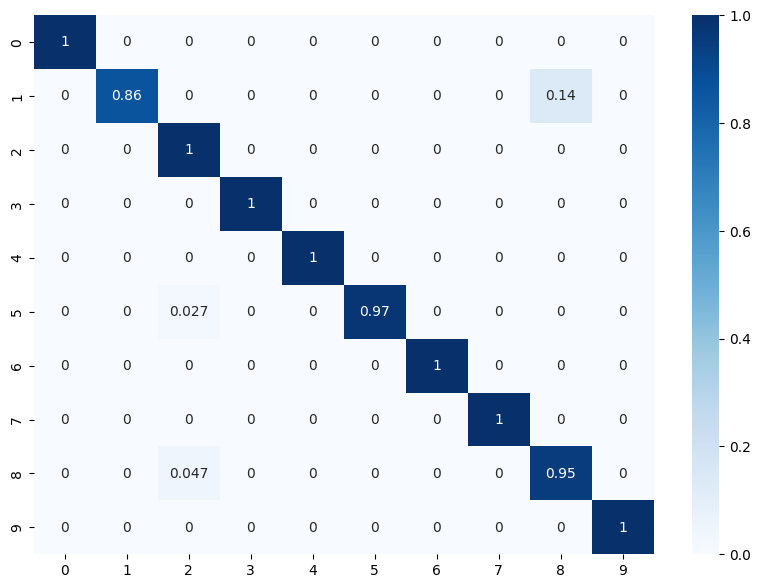

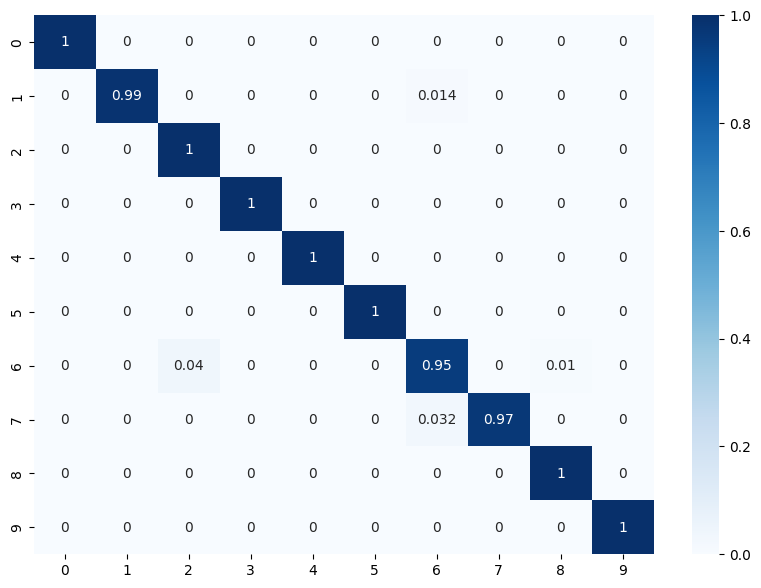

In [10]:
generate_confusion_matrix(encoder_tgt, classifier, test_dataloader_src, "cuda")
src_test_loss, src_test_acc = evaluate_src(encoder_tgt, classifier, phase='Test')
print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')
    
    generate_confusion_matrix(encoder_tgt, classifier, test_dataloader_tgt[phase], "cuda")
    tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt, classifier, test_dataloader_tgt[phase])
    print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}') 